In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Carregar o banco de dados
df = pd.read_excel(r"C:\Users\fluca\Desktop\2-unioeste\Ciências Econômicas\4º ano\2º bimestre\Econometria II\2º trabalho\heterocedasticidade\data\Trab_Cascavel_heteroc.xls")
df.head()

,Renda_pri,Idade
0,800,28
1,700,30
2,1200,32
3,510,30
4,700,42


In [5]:
df.rename(columns=({'Renda_pri':'renda','Idade':'idade'}), inplace=True)

In [6]:
df.head()

,renda,idade
0,800,28
1,700,30
2,1200,32
3,510,30
4,700,42


In [10]:
# Criar o modelo de regressão
modelo = smf.ols("renda ~ idade", data=df).fit()
print(modelo.summary())

# Calcular os valores ajustados (preditos de y)
y_estimado = modelo.fittedvalues

                            OLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     142.1
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           1.36e-32
Time:                        15:59:34   Log-Likelihood:            -1.2253e+05
No. Observations:               13075   AIC:                         2.451e+05
Df Residuals:                   13073   BIC:                         2.451e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    613.6543     78.073      7.860      0.0

In [13]:
# Calcular resíduos e quadrados dos resíduos
residuos = modelo.resid
residuos_quadrados = residuos ** 2

# Calcular os valores ajustados (preditos de y)
y_estimado = modelo.fittedvalues

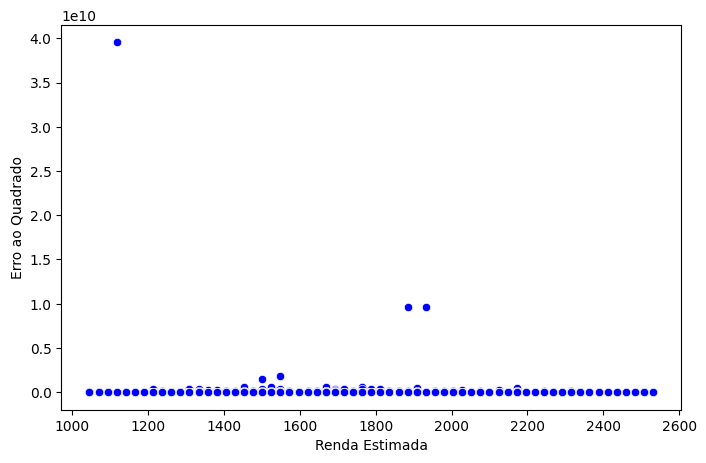

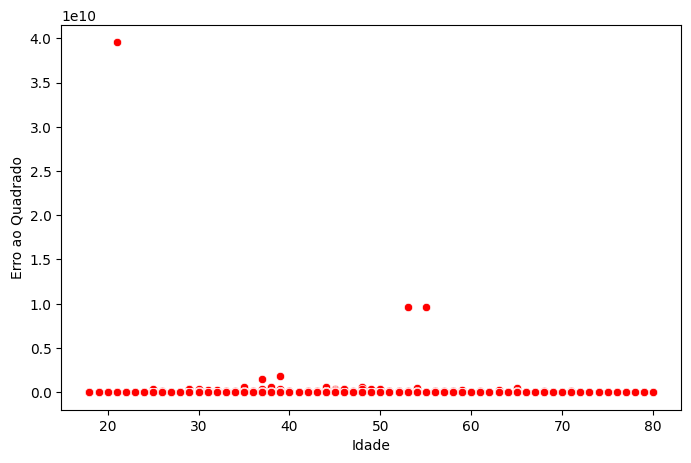

In [15]:
# Gráfico: Erro ao quadrado vs. Renda Estimada
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_estimado, y=residuos_quadrados, color='blue')
plt.xlabel("Renda Estimada")
plt.ylabel("Erro ao Quadrado")
plt.show()

# Gráfico: Erro ao quadrado vs. Idade
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['idade'], y=residuos_quadrados, color='red')
plt.xlabel("Idade")
plt.ylabel("Erro ao Quadrado")
plt.show()

In [23]:
# Ordenar a variável explicativa (idade) em ordem crescente
df_gq = df.sort_values(by="idade")
df_gq.tail()

,renda,idade
8841,2000,79
9505,1000,79
12354,510,79
12435,1500,80
8285,4000,80


In [26]:
from statsmodels.stats.diagnostic import het_goldfeldquandt

# Aplicar o teste de Goldfeld-Quandt
gq_test = het_goldfeldquandt(modelo.resid, df_gq[['idade']], alternative='increasing')

# Exibir resultados
print(f"Estatística F: {gq_test[0]}")
print(f"p-valor: {gq_test[1]}")

Estatística F: 6.640786130942513
p-valor: 0.0


In [16]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Calcular o teste de Breusch-Pagan
bp_test = het_breuschpagan(modelo.resid, modelo.model.exog)

# Exibir os resultados
print(f"Estatística Qui-quadrado: {bp_test[0]}")
print(f"p-valor: {bp_test[1]}")

Estatística Qui-quadrado: 0.0014927161965938573
p-valor: 0.9691808505818943


In [17]:
# Executando o Teste de Shapiro-Wilk nos resíduos
shapiro_test = shapiro(residuos)

# Exibir os resultados
print(f"Estatística do teste: {shapiro_test.statistic}")
print(f"p-valor: {shapiro_test.pvalue}")

NameError: name 'shapiro' is not defined

In [18]:
# Definir os pesos como o inverso da variável 'Renda'
pesos = 1 / df["idade"]

# Ajustar a regressão ponderada (WLS)
modelo_wls = sm.WLS(df["renda"], sm.add_constant(df["idade"]), weights=pesos).fit()

# Exibir o resumo do modelo corrigido
print(modelo_wls.summary())

                            WLS Regression Results                            
Dep. Variable:                  renda   R-squared:                       0.013
Model:                            WLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     166.9
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           6.01e-38
Time:                        16:48:04   Log-Likelihood:            -1.2324e+05
No. Observations:               13075   AIC:                         2.465e+05
Df Residuals:                   13073   BIC:                         2.465e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        437.6729     77.335      5.659      0.0

In [19]:
# Ajustar o modelo OLS (sem ponderação)
modelo_ols = sm.OLS(df["renda"], sm.add_constant(df["idade"])).fit()

In [20]:
# Criar um DataFrame com os coeficientes e erros padrão de ambos os modelos
comparacao = pd.DataFrame({
    "Coef. OLS": modelo_ols.params,
    "Desvio-Padrão OLS": modelo_ols.bse,
    "Coef. WLS": modelo_wls.params,
    "Desvio-Padrão WLS": modelo_wls.bse
})

# Exibir a comparação
print(comparacao)

        Coef. OLS  Desvio-Padrão OLS   Coef. WLS  Desvio-Padrão WLS
const  613.654283          78.073018  437.672910          77.334619
idade   23.968972           2.010646   28.750011           2.225433


In [34]:
import statsmodels.formula.api as smf
import numpy as np

# Criar uma nova variável com os resíduos absolutos
df["residuos_abs"] = np.abs(residuos)

# Ajustar o modelo auxiliar (regressão dos resíduos absolutos contra a variável independente)
modelo_glejser = smf.ols("residuos_abs ~ idade", data=df).fit()

# Exibir os resultados do teste
print(modelo_glejser.summary())

                            OLS Regression Results                            
Dep. Variable:           residuos_abs   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     245.4
Date:                Mon, 31 Mar 2025   Prob (F-statistic):           8.11e-55
Time:                        11:37:37   Log-Likelihood:            -1.2148e+05
No. Observations:               13075   AIC:                         2.430e+05
Df Residuals:                   13073   BIC:                         2.430e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -36.1883     72.054     -0.502      0.6

In [30]:
# Calcular a variância do modelo
variancia_modelo = residuos.var()
print(f"Variância do modelo: {variancia_modelo}")

Variância do modelo: 8082092.735962243


In [31]:
import numpy as np

# Número de observações e número de parâmetros (inclui intercepto)
n = len(df)
p = len(modelo.params)

# Calcular o RSE
rse = np.sqrt(sum(residuos**2) / (n - p))
print(f"Residual Standard Error (RSE): {rse}")

Residual Standard Error (RSE): 2843.01089759014
